### Step 0 : Init RoboFeeder Env
This cell sets up the environment for the RoboFeeder simulation by importing necessary modules and configuring the Python path.

In [ ]:
import os 
dir = os.getcwd()
if 'gym4ReaL' in dir:
    os.chdir(os.getcwd().split('examples')[0])
else:
    print("please set the working directory to the root of the gym4ReaL repository")

# check if the current working directory is the root of the gym4ReaL repository
os.getcwd()

### Step 1 : Import Required Modules
This cell imports the necessary modules and updates the system path to include the gym4ReaL repository. It also imports the robot simulator and matplotlib for visualization purposes.

In [ ]:
import sys
sys.path.append(os.getcwd())  # <-- path to the *parent* of gym4real
import os
import gymnasium as gym
import onnxruntime as ort
import numpy as np
import matplotlib.pyplot as plt
import mujoco

import gym4real.envs.robofeeder as rf
from gym4real.algorithms.robofeeder import baseline

### Step 2 : Load Pretrained PPO Agent
This cell loads the pretrained PPO agent for object detection using ONNX runtime. It sets up the path to the pretrained model, initializes the ONNX inference session with CUDA and CPU providers, and prepares the agent for later evaluation.


In [ ]:
current_dir = os.path.dirname(rf.__file__)
# Load the object detection network
pretrained_ppo_dir = os.path.join(current_dir, "utils", "Pretrained/")
# Init the ONNX runtime session
providers = ['CUDAExecutionProvider','CPUExecutionProvider']
pretrained_agent = ort.InferenceSession(pretrained_ppo_dir + 'PPO_Stoc.onnx',providers=providers)
# baseline_agent = baseline.Baseline_picking()

/usr/local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


### Step 2 : Test Simulator
import the simulator configuration file to pass the required parameters to run. 
Relevant parameters to adapt:

#### ObjectToPick
    NUMBER_OF_OBJECTS: 1           # (int) Number of objects to pick
    SHUFFLE_OBJECTS: True          # (bool) Shuffle object positions at reset
    OBJ_CORRECT_ORIENTATION: True  # (bool) Ensure objects have correct orientation

#### Simulator Setting
    IS_SIMULATION_REAL_TIME: False   # (bool) Run simulation in real time
    IS_SIMULATION_SHOWED: True       # (bool) Show simulation window
    IS_SIMULATION_RECORD: False      # (bool) Record simulation video
    RECORD_FOLDER : "." # (str) Folder to save recorded videos


In [ ]:
import shutil

# Copy the default configuration file to a new editable file
default_config_file = os.getcwd() + "/gym4real/envs/robofeeder/configuration.yaml"
config_file = os.getcwd() + "/examples/robofeeder/notebooks/configuration_editable.yaml"
shutil.copy(default_config_file, config_file)

### Step 3 : Initialize RoboFeeder Environment

This cell creates an instance of the RoboFeeder picking environment using the specified configuration file. The environment is initialized with the required settings for subsequent experiments and evaluations.


In [ ]:
env = gym.make('gym4real/robofeeder-picking-v0', config_file=config_file)

/usr/local/lib/python3.10/site-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment gym4real/robofeeder-picking-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
/usr/local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


### Step 4 : Evaluate Pretrained PPO Agent on Grid

This cell systematically evaluates the pretrained PPO agent's performance across a grid of object positions. For each grid point and random seed, the environment is reset, the object is placed at the specified coordinates, and the agent selects an action based on the current observation. The resulting reward is recorded for later analysis and visualization.


In [4]:
import random
# Set the random seed for reproducibility
seed = 42
def pose_object(simulator,coordinates,seed):
    x,y = coordinates
    x,y = (x+1)*simulator.configs["OBSERVATION_IMAGE_DIM"]/2,(y+1)*simulator.configs["OBSERVATION_IMAGE_DIM"]/2
    #random position and orientation
    res = simulator.pixel2World(np.array([x,y]))
    random.seed(seed)
    randomlist=random.choices(simulator.possibleOrietnation,k=4)
    simulator.data.qpos[:3] = [res[0], res[1], 0.21]
    # the rotation of the obj is correct on z axis 
    simulator.data.qpos[3]= randomlist[0]
    simulator.data.qpos[6]= randomlist[1]
    mujoco.mj_step(simulator.model, simulator.data,900) 
    simulator.renderer.update_scene(simulator.data, camera="top_down")

### Step 5 : Evaluate Baseline Agent on Grid

This cell evaluates the performance of a baseline picking agent across a grid of object positions. For each grid point and random seed, the environment is reset, the object is placed at the specified coordinates, and the baseline agent selects an action. The resulting reward is recorded for subsequent analysis and comparison with the pretrained PPO agent.


In [31]:
def calculate_avg_reward(grid_size,result_iter,x_vals,y_vals):
    reward_grid = np.zeros((grid_size, grid_size))
    count_grid = np.zeros((grid_size, grid_size))

    # Accumulate rewards
    for iteration in result_iter:
        for x, y, rew in iteration:
            i = np.argmin(np.abs(x_vals - x))
            j = np.argmin(np.abs(y_vals - y))
            reward_grid[j, i] += rew  # Note: y -> row, x -> col
            count_grid[j, i] += 1

    # Compute average, handling divide-by-zero
    avg_reward_grid = np.divide(reward_grid, count_grid, where=count_grid != 0)
    return avg_reward_grid

### Step 6 : Run Baseline Agent on Grid

This cell initializes the baseline picking agent and evaluates its performance over a grid of object positions. For each grid point and random seed, the environment is reset, the object is placed at the specified coordinates, and the baseline agent selects an action. The resulting reward is recorded for each position and iteration, enabling later comparison with the pretrained PPO agent.


In [10]:
def plot_avg_reward_heatmap(result_iter, x_vals, y_vals, grid_size=10, title='Heatmap of Average Rewards Over Grid Positions'):
    """
    Generate and display a heatmap of average rewards over a grid of (x, y) positions.

    Parameters:
    - result_iter: List of lists containing tuples (x, y, reward) per seed/iteration
    - x_vals: 1D array of x grid values
    - y_vals: 1D array of y grid values
    - grid_size: Number of tiles in each dimension (assumes square grid)
    - title: Title of the heatmap plot
    """
    reward_grid = np.zeros((grid_size, grid_size))
    count_grid = np.zeros((grid_size, grid_size))

    # Accumulate rewards
    for iteration in result_iter:
        for x, y, rew in iteration:
            i = np.argmin(np.abs(x_vals - x))
            j = np.argmin(np.abs(y_vals - y))
            reward_grid[j, i] += rew  # Note: y -> row, x -> col
            count_grid[j, i] += 1

    # Compute average, handling divide-by-zero
    avg_reward_grid = np.divide(reward_grid, count_grid, where=count_grid != 0)

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(avg_reward_grid, origin='lower', extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]], cmap='viridis')
    plt.colorbar(label='Average Reward')
    plt.title(title)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.grid(False)
    plt.show()

### Step 7 : Evaluate Pretrained PPO Agent on Grid

This cell evaluates the performance of the pretrained PPO agent across a grid of object positions. For each grid point and random seed, the environment is reset, the object is placed at the specified coordinates, and the agent selects an action based on the current observation. The resulting reward is recorded for each position and iteration, enabling later analysis and comparison with the baseline agent.


In [15]:
grid_size = 10  # 5x5 grid = 25 iterations
x_vals = np.linspace(-0.8, 0.8, grid_size)
y_vals = np.linspace(-0.8, 0.8, grid_size)

iterations = 5
seeds = [random.randint(0, 100) for _ in range(iterations)]
pretrained_agent_result = [[] for _ in range(iterations)]

for l in range(iterations):
    seed = seeds[l]
    print(f"Iteration {l + 1} with seed {seed}")
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            print(f"Iteration {i * grid_size + j + 1}: Position = ({x:.2f}, {y:.2f})")
            env.reset()
            pose_object(env.unwrapped.simulator, (x, y),seed)
            frame = env.unwrapped.simulator.renderer.render()
            current_obs = env.unwrapped.rgb2gray(env.unwrapped.simulator.get_state())
            action = pretrained_agent.run(None, {"input": np.expand_dims(current_obs,axis=0)})[0][0]
            obs,rew,done,_,_ = env.step(action)
            pretrained_agent_result[l].append((x, y, rew))


Iteration 1 with seed 36
Iteration 1: Position = (-0.80, -0.80)
Iteration 2: Position = (-0.80, -0.62)
Iteration 3: Position = (-0.80, -0.44)
Iteration 4: Position = (-0.80, -0.27)
Iteration 5: Position = (-0.80, -0.09)
Iteration 6: Position = (-0.80, 0.09)
Iteration 7: Position = (-0.80, 0.27)
Iteration 8: Position = (-0.80, 0.44)
Iteration 9: Position = (-0.80, 0.62)
Iteration 10: Position = (-0.80, 0.80)
Iteration 11: Position = (-0.62, -0.80)
Iteration 12: Position = (-0.62, -0.62)
Iteration 13: Position = (-0.62, -0.44)
Iteration 14: Position = (-0.62, -0.27)
Iteration 15: Position = (-0.62, -0.09)
Iteration 16: Position = (-0.62, 0.09)
Iteration 17: Position = (-0.62, 0.27)
Iteration 18: Position = (-0.62, 0.44)
Iteration 19: Position = (-0.62, 0.62)
Iteration 20: Position = (-0.62, 0.80)
Iteration 21: Position = (-0.44, -0.80)
Iteration 22: Position = (-0.44, -0.62)
Iteration 23: Position = (-0.44, -0.44)
Iteration 24: Position = (-0.44, -0.27)
Iteration 25: Position = (-0.44, -

### Step 8 : Evaluate Baseline Agent on Grid

This cell initializes the baseline picking agent and evaluates its performance over a grid of object positions. For each grid point and random seed, the environment is reset, the object is placed at the specified coordinates, and the baseline agent selects an action. The resulting reward is recorded for each position and iteration, enabling later analysis and comparison with the pretrained PPO agent.


In [16]:
baseline_agent = baseline.Baseline_picking(env.action_space)


grid_size = 10  # 5x5 grid = 25 iterations
x_vals = np.linspace(-0.8, 0.8, grid_size)
y_vals = np.linspace(-0.8, 0.8, grid_size)

iterations = 5
baseline_result = [[] for _ in range(iterations)]

for l in range(iterations):
    seed = seeds[l]
    print(f"Iteration {l + 1} with seed {seed}")
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            print(f"Iteration {i * grid_size + j + 1}: Position = ({x:.2f}, {y:.2f})")
            env.reset()
            pose_object(env.unwrapped.simulator, (x, y),seed)
            frame = env.unwrapped.simulator.renderer.render()
            current_obs = env.unwrapped.rgb2gray(env.unwrapped.simulator.get_state())
            action = baseline_agent.act()
            obs,rew,done,_,_ = env.step(action)
            baseline_result[l].append((x, y, rew))


Iteration 1 with seed 36
Iteration 1: Position = (-0.80, -0.80)
Iteration 2: Position = (-0.80, -0.62)
Iteration 3: Position = (-0.80, -0.44)
Iteration 4: Position = (-0.80, -0.27)
Iteration 5: Position = (-0.80, -0.09)
Iteration 6: Position = (-0.80, 0.09)
Iteration 7: Position = (-0.80, 0.27)
Iteration 8: Position = (-0.80, 0.44)
Iteration 9: Position = (-0.80, 0.62)
Iteration 10: Position = (-0.80, 0.80)
Iteration 11: Position = (-0.62, -0.80)
Iteration 12: Position = (-0.62, -0.62)
Iteration 13: Position = (-0.62, -0.44)
Iteration 14: Position = (-0.62, -0.27)
Iteration 15: Position = (-0.62, -0.09)
Iteration 16: Position = (-0.62, 0.09)
Iteration 17: Position = (-0.62, 0.27)
Iteration 18: Position = (-0.62, 0.44)
Iteration 19: Position = (-0.62, 0.62)
Iteration 20: Position = (-0.62, 0.80)
Iteration 21: Position = (-0.44, -0.80)
Iteration 22: Position = (-0.44, -0.62)
Iteration 23: Position = (-0.44, -0.44)
Iteration 24: Position = (-0.44, -0.27)
Iteration 25: Position = (-0.44, -

### Step 9 : Visualize Reward Heatmaps

This cell visualizes the average reward heatmaps for both the baseline and pretrained PPO agents. The `plot_avg_reward_heatmap` function is used to generate and display heatmaps, providing a clear comparison of agent performance across different object positions on the grid.


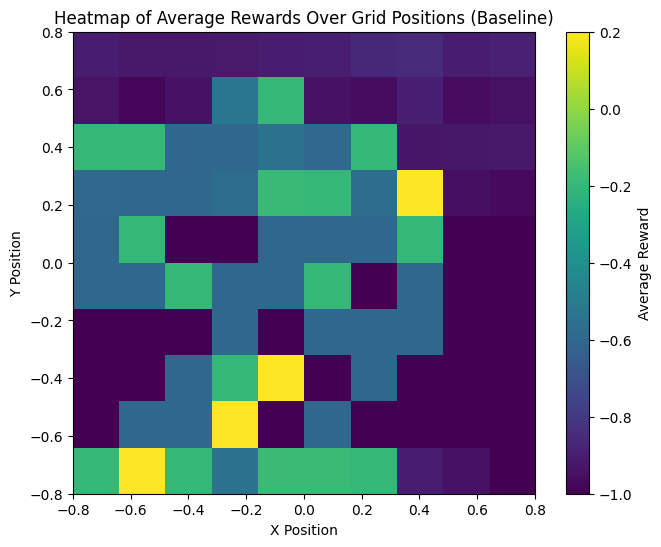

In [ ]:
plot_avg_reward_heatmap(baseline_result, x_vals, y_vals, grid_size=10, title='Heatmap of Average Rewards Over Grid Positions (Baseline)')
plot_avg_reward_heatmap(pretrained_agent_result, x_vals, y_vals, grid_size=10, title='Heatmap of Average Rewards Over Grid Positions (Pretrained PPO)')

### Step 10 : Overlay Reward Heatmap on Simulator Frame

This cell defines a function to overlay the average reward heatmap onto a rendered frame from the simulator. The function takes the environment, a function to pose the object, a function to calculate the average reward, and the reward data as inputs. It renders the simulator frame, resizes and normalizes the heatmap to match the frame dimensions, and overlays the heatmap on the simulator image for visual analysis. The resulting visualization can be saved as an image file.


In [39]:
from scipy.ndimage import zoom

def overlay_heatmap_on_simulator_frame(env, pose_object, calculate_avg_reward, 
                                       result_data, x_vals, y_vals, grid_size=10, seed=0, 
                                       alpha=0.6, cmap='viridis', title='Overlay: Heatmap on Simulator Frame', save_figure=True,
    fig_name='heatmap_overlay.png'):
    """
    Overlays an average reward heatmap on a rendered simulator frame.

    Parameters:
    - env: Gym-like environment with simulator and renderer
    - pose_object: Function to pose the object at (0, 0), seed controlled
    - calculate_avg_reward: Function to compute average reward heatmap (returns 2D array)
    - result_data: Input data for the reward calculation
    - x_vals, y_vals: Grid values for heatmap calculation
    - grid_size: Resolution of heatmap (assumed square)
    - seed: Seed for posing the object
    - alpha: Transparency of the heatmap overlay
    - cmap: Colormap used for the heatmap
    - title: Plot title
    """

    # Pose object and render base image
    pose_object(env.unwrapped.simulator, (0, 0), seed)
    frame = env.unwrapped.simulator.renderer.render()
    background_img = frame
    print("Background image shape:", background_img.shape)

    # Calculate heatmap
    heatmap = calculate_avg_reward(grid_size, result_data, x_vals, y_vals)

    # Resize heatmap to match image size
    heatmap_resized = zoom(
        heatmap,
        (background_img.shape[0] / heatmap.shape[0],
         background_img.shape[1] / heatmap.shape[1])
    )

    # Normalize heatmap (0 to 1) for colormap mapping
    heatmap_norm = (heatmap_resized - np.min(heatmap_resized)) / (np.ptp(heatmap_resized) + 1e-8)

    # Plot overlay
    plt.figure(figsize=(8, 6))
    plt.imshow(background_img)
    plt.imshow(heatmap_norm, cmap=cmap, alpha=alpha, origin='lower')  # origin='lower' aligns with simulator space
    plt.colorbar(label='Average Reward')
    plt.title(title)
    plt.axis('off')
    if save_figure:
        plt.savefig(fig_name, bbox_inches='tight', dpi=300)
    else:
        plt.show()




### Step 11 : Overlay Heatmap Visualization

This cell overlays the average reward heatmaps for both the baseline and pretrained PPO agents onto a rendered frame from the simulator. The `overlay_heatmap_on_simulator_frame` function is called for each agent, generating composite images that visually compare agent performance across the workspace. The resulting images are saved for further analysis and presentation.


Background image shape: (300, 300, 3)


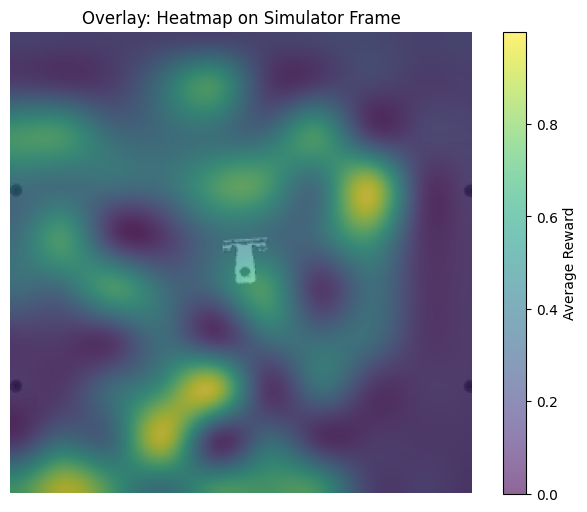

In [ ]:
overlay_heatmap_on_simulator_frame(
    env=env,
    pose_object=pose_object,
    calculate_avg_reward=calculate_avg_reward,
    result_data=baseline_result,
    x_vals=x_vals,
    y_vals=y_vals,
    grid_size=10,
    save_figure=True,
    fig_name='heatmap_overlay_baseline.png',
    seed=42
)

overlay_heatmap_on_simulator_frame(
    env=env,
    pose_object=pose_object,
    calculate_avg_reward=calculate_avg_reward,
    result_data=pretrained_agent_result,
    x_vals=x_vals,
    y_vals=y_vals,
    grid_size=10,
    save_figure=True,
    fig_name='heatmap_overlay_ppo.png',
    seed=42
)